# Immunofluorescence Cardiomyocyte Segmentation on QuPath Selected ROI

In this notebook we will provide a workflow demonstration to load RAW CZI IF image from Axioscan 7, together with user predefined ROI from QuPath to perform cell segmentation based on membrane stained cardiomyocyte channel (AF488-WGA). The process includes 3 steps, including:

1. Effective data I/O and data normalization
2. Inference of 2D [PlantSeg](https://github.com/hci-unihd/plant-seg) pre-trained model
3. Post segmentation filtering

In [1]:
from aicsimageio import AICSImage
from aicsimageio.writers.ome_tiff_writer import OmeTiffWriter
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from skimage import exposure
import SimpleITK as sitk
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
from plantseg.predictions.functional.predictions import unet_predictions
from plantseg.segmentation.functional.segmentation import *
from skimage.segmentation import relabel_sequential
from cellpose import core, utils, io, models, metrics, plot
from cellpose.plot import *

/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/cupy/_environment.py:445: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [2]:
channels = {
    "DAPI": "Nuclei",
    "AF488-WGA": "Boundary",
    "AF555-PDGFRa": "Fibroblast",
    "AF647-Ki67": "Proliferation",
    "AF751-CD31": "Endothelial Cells",
    "AF594-cTnl": "Cardiomyocytes"
}

channels_cmap = {
    "DAPI": "Blues",
    "AF488-WGA": "Greys",
    "AF555-PDGFRa": "RdPu",
    "AF647-Ki67": "Reds",
    "AF751-CD31": "Greens",
    "AF594-cTnl": "PuRd"
}

## Data IO

In [3]:
# IMG_PATH = "/media/Data3/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no17_NS_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488.czi"
# OBJ_PATH = "/media/Data3/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no17_NS_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488.czi - Scene #3.geojson"
# OUT_DIR = "/media/Data3/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no17_NS_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488_res"
# scene_idx=2

IMG_PATH = "/media/Data3/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no20_FR_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488.czi"
OBJ_PATH = "/media/Data3/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no20_FR_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488.czi - Scene #2.geojson"
OUT_DIR = "/media/Data3/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no20_FR_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488_res"
scene_idx=1

In [4]:
img = AICSImage(IMG_PATH)
img.set_scene(scene_idx)
img_dask = img.get_image_dask_data("CYX")
img_dask.persist()
img_dask

dask.array<transpose, shape=(6, 14988, 16438), dtype=uint16, chunksize=(6, 3344, 3344), chunktype=numpy.ndarray>

In [5]:
# scaled image
img_dask_scaled = img_dask[:,::10,::10]
img_dask_scaled = img_dask_scaled.compute()

In [6]:
# load cropped region file
regions = gpd.read_file(OBJ_PATH)
regions

,id,objectType,name,geometry
0,1c8c493f-c5d4-4fef-9d05-c40b68cd65c2,annotation,RZ1,"POLYGON ((5373.00000 5186.00000, 6373.00000 51..."
1,a2c91635-74d9-414e-a5de-b7b2ea0c163e,annotation,RZ2,"POLYGON ((4741.00000 6283.00000, 5741.00000 62..."
2,9fcb175c-4bf3-4169-84a7-a86276102c56,annotation,BZ5,"POLYGON ((12291.00000 10749.00000, 13291.00000..."
3,23446d3e-e890-4218-8f0b-e37402f47837,annotation,BZ4,"POLYGON ((11886.00000 9732.00000, 12886.00000 ..."
4,c39970ba-57cf-4279-b192-42141eb7c037,annotation,BZ3,"POLYGON ((12357.00000 7473.00000, 13357.00000 ..."
5,11a6e308-8968-4e61-811e-3f86af430753,annotation,BZ2,"POLYGON ((12552.00000 6435.00000, 13552.00000 ..."
6,8029ad8d-ab97-4614-a191-1d59c3c0914c,annotation,BZ1,"POLYGON ((12316.00000 5424.00000, 13316.00000 ..."


[(5373.0, 5186.0), (6373.0, 5186.0), (6373.0, 6186.0), (5373.0, 6186.0), (5373.0, 5186.0)]
[(4741.0, 6283.0), (5741.0, 6283.0), (5741.0, 7283.0), (4741.0, 7283.0), (4741.0, 6283.0)]
[(12291.0, 10749.0), (13291.0, 10749.0), (13291.0, 11749.0), (12291.0, 11749.0), (12291.0, 10749.0)]
[(11886.0, 9732.0), (12886.0, 9732.0), (12886.0, 10732.0), (11886.0, 10732.0), (11886.0, 9732.0)]
[(12357.0, 7473.0), (13357.0, 7473.0), (13357.0, 8473.0), (12357.0, 8473.0), (12357.0, 7473.0)]
[(12552.0, 6435.0), (13552.0, 6435.0), (13552.0, 7435.0), (12552.0, 7435.0), (12552.0, 6435.0)]
[(12316.0, 5424.0), (13316.0, 5424.0), (13316.0, 6424.0), (12316.0, 6424.0), (12316.0, 5424.0)]


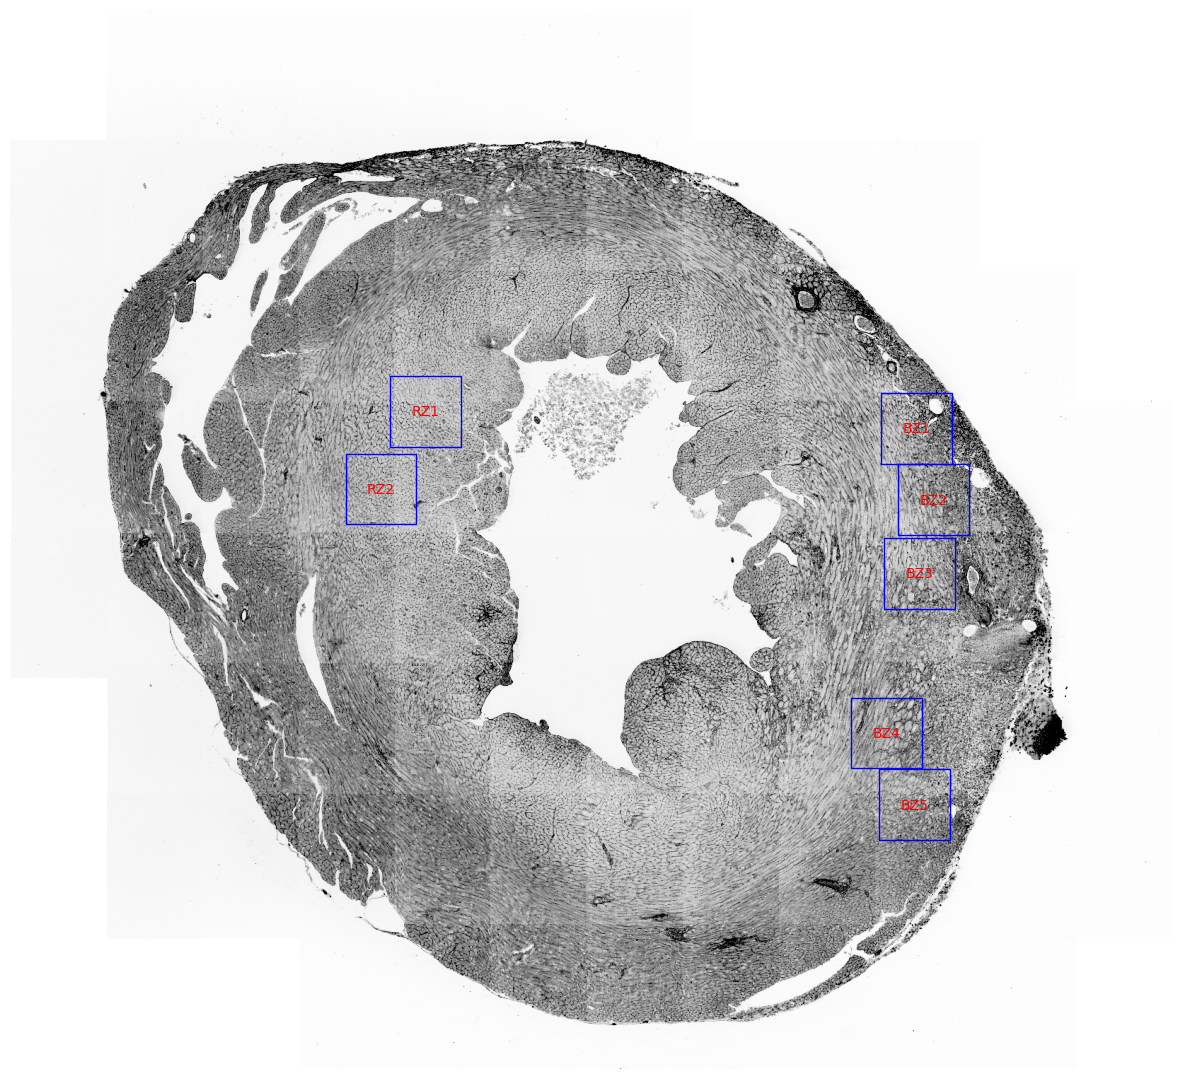

In [7]:
# Create a Rectangle patch
figure, ax = plt.subplots(1,1,figsize=(15,15))
frame = img_dask_scaled[1,:,:]
tail = 1
pl, pu = np.percentile(np.ravel(frame), (tail, 100-tail))
ax.imshow(exposure.rescale_intensity(frame, in_range=(pl, pu),out_range=(0,255)),cmap="Greys")
ax.axis("off")

for idx, row in regions.iterrows():
    coordinates = list(row["geometry"].exterior.coords)
    print(coordinates)
    SUBREGION = [coordinates[0][0], coordinates[0][1], coordinates[2][0]-coordinates[0][0],coordinates[2][1]-coordinates[0][1]]
    # SUBREGION = [coordinates[0][0], coordinates[0][1], coordinates[0][0]-coordinates[2][0],coordinates[0][1]-coordinates[2][1]]
    # SUBREGION = [coordinates[1][1], coordinates[0][0], coordinates[2][1]-coordinates[0][1],coordinates[2][0]-coordinates[0][0]]
    
    rect = patches.Rectangle((SUBREGION[0]/10,SUBREGION[1]/10), SUBREGION[2]/10, SUBREGION[3]/10, linewidth=1, edgecolor='b', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.text(row["geometry"].centroid.x/10, row["geometry"].centroid.y/10, row["name"], ha="center", va="center",color="r")

## Segmentation

In [15]:
res = []

for idx, row in tqdm(regions.iterrows(),desc="Segmenting"):
    coordinates = list(row["geometry"].exterior.coords)
    SUBREGION = [coordinates[0][0], coordinates[0][1], coordinates[2][0]-coordinates[0][0],coordinates[2][1]-coordinates[0][1]]

    img_dask_subset = img_dask[1,SUBREGION[1]:SUBREGION[1]+SUBREGION[3],SUBREGION[0]:SUBREGION[0]+SUBREGION[2]]

    frame_rescaled = exposure.rescale_intensity(img_dask_subset, in_range=(pl, pu),out_range=(0,1))

    # pred = unet_predictions(frame_rescaled[np.newaxis,:,:],"confocal_2D_unet_ovules_ds2x",patch=[1,1024,1024])
    pred = unet_predictions(frame_rescaled[np.newaxis,:,:],"lightsheet_2D_unet_root_ds1x",patch=[1,1000,1000])
    # pred = unet_predictions(frame_rescaled[np.newaxis,:,:],"confocal_2D_unet_sa_meristem_cells",patch=[1,1024,1024])

    # mask = mutex_ws(pred,superpixels=None,beta=0.85,post_minsize=100,n_threads=6)
    mask = mutex_ws(pred,superpixels=None,beta=0.7,post_minsize=100,n_threads=6)
    mask_relab, fw, inv = relabel_sequential(mask[0,:,:])
    outlines = utils.masks_to_outlines(mask_relab)

    outX, outY = np.nonzero(outlines)
    img0 = image_to_rgb(frame_rescaled, channels=[0,0])
    imgout= img0.copy()
    imgout[outX, outY] = np.array([255,0,0]) # pure red

    res.append({
        "name": row["name"],
        "img": img_dask_subset,
        "pred": pred[0,:,:],
        "mask": mask_relab,
        "overlay": imgout,
    })
    # break

Segmenting: 0it [00:00, ?it/s]

2024-01-10 13:27:13,672 [MainThread] INFO PlantSeg - Using batch size of 1 for prediction


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
Segmenting: 1it [00:08,  8.97s/it]

2024-01-10 13:27:24,918 [MainThread] INFO PlantSeg - Using batch size of 1 for prediction


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
Segmenting: 2it [00:20, 10.28s/it]

2024-01-10 13:27:33,366 [MainThread] INFO PlantSeg - Using batch size of 1 for prediction


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]
Segmenting: 3it [00:28,  9.48s/it]

2024-01-10 13:27:44,630 [MainThread] INFO PlantSeg - Using batch size of 1 for prediction


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]
Segmenting: 4it [00:40, 10.23s/it]

2024-01-10 13:27:53,285 [MainThread] INFO PlantSeg - Using batch size of 1 for prediction


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]
Segmenting: 5it [00:48,  9.63s/it]

2024-01-10 13:28:07,301 [MainThread] INFO PlantSeg - Using batch size of 1 for prediction


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
Segmenting: 6it [01:02, 11.15s/it]

2024-01-10 13:28:15,734 [MainThread] INFO PlantSeg - Using batch size of 1 for prediction


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
Segmenting: 7it [01:11, 10.18s/it]


(-0.5, 999.5, 999.5, -0.5)

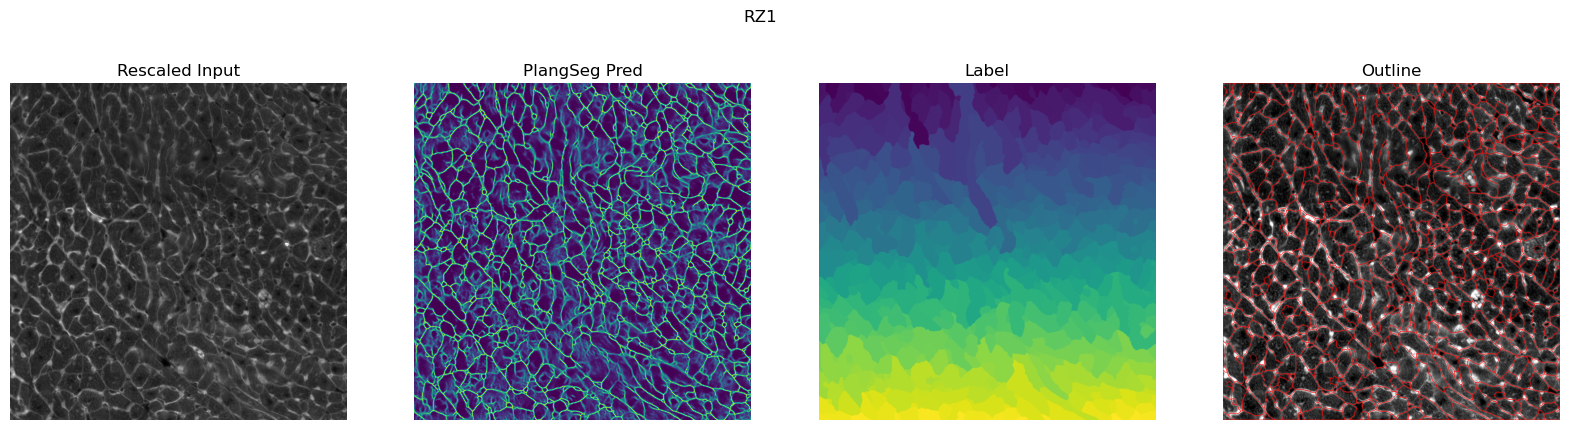

In [16]:
# plot the output
disp_idx = 0

fig, axs = plt.subplots(1,4,figsize=(20,5))
fig.suptitle(res[disp_idx]["name"])

axs[0].imshow(res[disp_idx]["img"],cmap="gray")
axs[0].set_title('Rescaled Input')
axs[0].axis('off')

axs[1].imshow(res[disp_idx]["pred"])
axs[1].set_title('PlangSeg Pred')
axs[1].axis('off')

axs[2].imshow(res[disp_idx]["mask"])
axs[2].set_title('Label')
axs[2].axis('off')

axs[3].imshow(res[disp_idx]["overlay"])
axs[3].set_title('Outline')
axs[3].axis('off')

# Export results

In [17]:
for i, res_ in tqdm(enumerate(res),desc="Result saving"):
    out_dir_ = os.path.join(OUT_DIR,res_["name"])
    os.makedirs(out_dir_,exist_ok=True)
    OmeTiffWriter.save(res_["img"],os.path.join(out_dir_,"img.ome.tif"),dim_order="YX")
    OmeTiffWriter.save(res_["pred"],os.path.join(out_dir_,"pred.ome.tif"),dim_order="YX")
    OmeTiffWriter.save(res_["mask"],os.path.join(out_dir_,"mask.ome.tif"),dim_order="YX")
    OmeTiffWriter.save(res_["overlay"],os.path.join(out_dir_,"overlay.ome.tif"),dim_order="YXS")

Result saving: 7it [00:56,  8.08s/it]
